# PUC Minas Pós Graduação em Ciência de Dados e Big Data (2019-2020) Trabalho de Conclusão de Curso

Aluno: Ivanilton Ferreira Bastos

Notebook relativo ao Trabalho de Conclusão de Curso em Ciência de Dados e Big Data.

Titulo:Análise de series temporais e predição de vendas de veículos novos no Brasil utilizando técnica de Web Scrapping e ARIMA, período utilizado de 2011 a 2020.
Foram utilizados dados aberto do Site www.autoo.com.br

In [414]:
#Importando Bibliotecas utilizadas 
import pandas as pd
import warnings
import requests
from bs4 import BeautifulSoup
import warnings
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA





In [3]:
#Função para o Scraping de dados da Web
def buscar_Tabela():
    
    url = 'https://www.autoo.com.br/emplacamentos/'
    print(url)
    req = requests.get(url)
    if req.status_code == 200:
        print('Requisição bem sucedida!')
        content = req.content
        
    soup = BeautifulSoup(content, 'html.parser')
    table = soup.find(name='table')
    
    table_str = str(table)
    tabela = 'Emplacamentos'
    dfDados = pd.read_html(table_str)[0]
    
    dfDados = dfDados.to_csv(tabela + '.csv', encoding = 'utf-8')
   
    print('Foi criado o arquivo de Dados ' + tabela+ '.csv')
    
def teste_adf(serie):
    '''
    Função para exibir o teste Augmented Dickey-Fuller.
    '''
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
       

In [4]:
#https://www.autoo.com.br/emplacamentos/
#Emplacamentos
buscar_Tabela()

https://www.autoo.com.br/emplacamentos/
Requisição bem sucedida!
Foi criado o arquivo de Dados Emplacamentos.csv


In [5]:
#Alocando os dados do arquivo csv criado a partir da tabela da web
#Tratamento da coluna Ano para o formato Data
dfEmplacamentos = pd.read_csv('Emplacamentos.csv', encoding='utf-8')
#dfEmplacamentos.set_index('Ano',inplace=True)
#dfEplacamentos[['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']] = dfEmplacamentos[['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']].astype(float)

#dfEmplacamentos['Ano']= dfEmplacamentos['Ano'].dt.year
#dfEmplacamentos['Ano'] = pd.DatetimeIndex(dfEmplacamentos['Ano']).year 
dfEmplacamentos.head()

,Unnamed: 0,Ano,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
0,0,2021,162.761,158.210,177.013,163.830,175.517,169.118,NaN,NaN,NaN,NaN,NaN,NaN,1.006.449
1,1,2020,184.229,192.554,155.676,51.383,56.656,122.785,162.947,173.058,198.495,205.038,214.256,232.815,1.949.892
2,2,2019,190.684,189.812,199.540,221.244,234.066,213.359,232.024,230.500,223.048,241.088,230.709,252.093,2.658.167
3,3,2018,175.448,151.635,199.867,209.961,194.913,194.950,208.402,238.511,204.503,244.394,220.927,224.557,2.468.068
4,4,2017,143.439,132.280,183.701,152.263,189.960,189.089,178.646,209.736,193.447,196.517,196.909,204.311,2.170.298


# Tratamento dos dados

In [6]:
#Verificando o tipo dos Dados
dfEmplacamentos.dtypes


Unnamed: 0      int64
Ano             int64
Jan           float64
Fev           float64
Mar           float64
Abr           float64
Mai           float64
Jun           float64
Jul           float64
Ago           float64
Set           float64
Out           float64
Nov           float64
Dez           float64
Total          object
dtype: object

In [7]:
#excluindo a coluna Total e recriando a partir da soma dos valor 
dfEmplacamentos.drop('Total', axis=1, inplace=True)
dfEmplacamentos['Total de Vendas'] = dfEmplacamentos.sum(axis=1)
dfEmplacamentos = dfEmplacamentos.head(15)

In [8]:
dfEmplacamentos.dtypes

Unnamed: 0           int64
Ano                  int64
Jan                float64
Fev                float64
Mar                float64
Abr                float64
Mai                float64
Jun                float64
Jul                float64
Ago                float64
Set                float64
Out                float64
Nov                float64
Dez                float64
Total de Vendas    float64
dtype: object

In [9]:
#Verificando os campos com valores em branco
dfEmplacamentos.isnull().sum()

Unnamed: 0         0
Ano                0
Jan                0
Fev                0
Mar                0
Abr                0
Mai                0
Jun                0
Jul                1
Ago                1
Set                1
Out                1
Nov                1
Dez                1
Total de Vendas    0
dtype: int64

In [10]:
#Selecionando apenas os últimos dez anos 
#dfEmplacamentos = dfEmplacamentos.head(10)

In [11]:
#retirando a coluna criada pelo pandas para indexação 
dfEmplacamentos.drop('Unnamed: 0', axis=1, inplace=True)
dfEmplacamentos.drop(0,inplace=True)

In [12]:
#Ordenando os dados pela coluna Ano
dfEmplacamentos.sort_values('Ano', ascending=True, inplace=True)
#dfEmplacamentos = dfEmplacamentos['Total de Vendas'].replace(',', '')

## Análise exploratória dos dados

Para orientar a análise dos dados realizei algumas pergundas

1. Qual foi o melhor ano para as vendas de veículos no Brasil

2. Qual foi o pior ano para as vendas de veículos no Brasil
3. Como foi o comportamento das vendas de veículos por Trimestre
4. parametros estatisticos para as vendas anuais e trimestrais


In [13]:
#Dados Estatisticos sobre as variáveis
dfEstatisticas = dfEmplacamentos.drop(columns=['Ano','Total de Vendas'],axis=1).describe()
dfEstatisticas
Media = dfEstatisticas.loc['mean']
dfMedia = pd.DataFrame(data=Media,columns=['Mes','Media de Vendas'])
dfMedia =  dfEstatisticas.loc['mean']
dfMedia = pd.DataFrame(np.array(Media).reshape(12, 1), columns = list("A"))
#dataset = pd.DataFrame({'Column1': Media[:, 0], 'Column2': data[:, 1]})
#ataset


In [14]:
dfMedia = pd.DataFrame(np.array(Media).reshape(12, 1), columns = list("A"))
dfMedia


,A
0,212.283385
1,195.452923
2,232.725000
3,219.270077
4,222.856462
5,234.664077
6,249.967385
7,252.773000
8,242.683923
9,247.213615


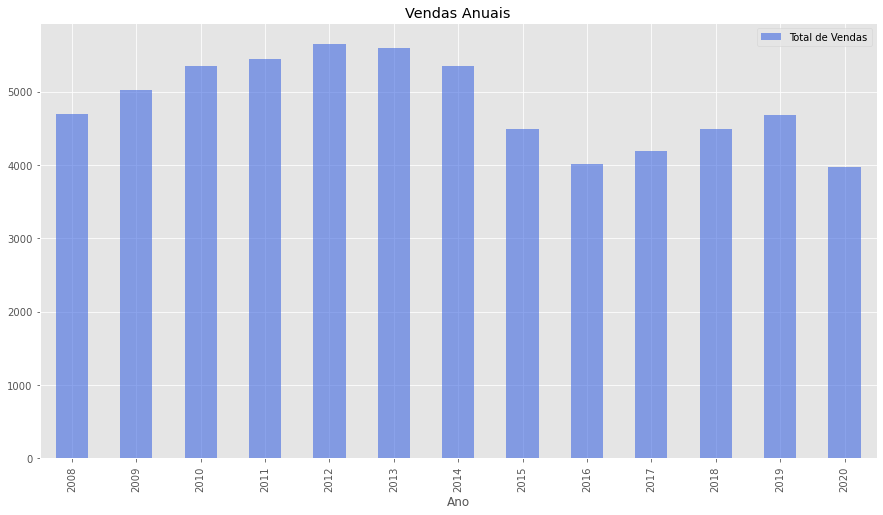

In [15]:
#Melhor Ano para as Vendas de Veículos no Brasil
plt.style.use("ggplot")
dfEmplacamentos[['Ano','Total de Vendas']].plot(kind='bar', x='Ano', figsize=(15,8),title='Vendas Anuais', grid='True',alpha = .6, color = "royalblue")
#dfMedia[['Ano','Total de Vendas']].plot(kind='line', figsize=(15,8),title='Vendas Anuais', grid='True')
plt.style.use("ggplot")
plt.show()


### Podemos verificar através do gráfico de barras que o pior ano para as vendas de veículos foi o de 2016 e que os melhores anos foram os de 2012 e 2013.


In [16]:
#plt.style.use("ggplot")
#plt.figure(figsize = (15, 8))
#dfEmplacamentos[['Ano','Total de Vendas']].hist(bins = 40, ec = "k", alpha = .6, color = "royalblue")
#plt.title('Ano')
#plt.xlabel("Período")
#plt.ylabel("Vendas em Milhares de Veículos")

In [17]:
#Dados Estatisticos sobre as variáveis
dfEmplacamentos.drop(columns=['Ano','Total de Vendas',],axis=1).describe()

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.00000,13.000000,13.000000,13.000000,13.000000
mean,212.283385,195.452923,232.725000,219.270077,222.856462,234.664077,249.967385,252.77300,242.683923,247.213615,239.189154,269.258154
std,49.515983,38.882205,52.365884,68.177787,65.579275,60.618830,58.878469,63.99558,49.759413,52.262158,51.367664,65.966842
min,143.439000,132.280000,155.676000,51.383000,56.656000,122.785000,162.947000,173.05800,154.913000,154.827000,166.118000,183.648000
25%,184.229000,178.395000,199.540000,209.961000,194.913000,194.950000,208.402000,209.73600,198.495000,205.038000,196.909000,208.184000
50%,201.186000,191.029000,226.088000,224.152000,234.066000,242.716000,272.752000,238.51100,253.935000,244.394000,230.709000,252.093000
75%,242.913000,222.087000,268.057000,261.726000,273.866000,286.547000,284.763000,296.35200,291.235000,287.407000,287.858000,335.090000
max,299.189000,258.508000,337.119000,316.241000,300.315000,340.202000,351.805000,404.66400,296.424000,326.027000,311.231000,359.354000


<AxesSubplot:>

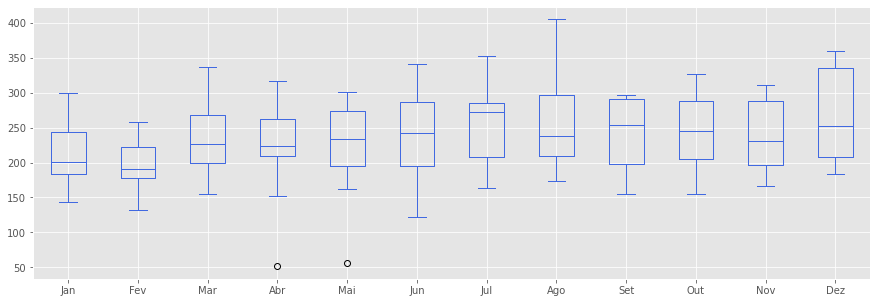

In [18]:
#Gráfico de Caixas para análises estatísticas das vendas pelos meses e os outliers(mínimos,máximos,médias, quartis e as discrepâncias) das vendas mensais de 2011 a 2020.
plt.style.use("ggplot")
dfEmplacamentos.drop(columns=['Ano','Total de Vendas'], axis=1).boxplot(color='#4169e1',figsize='15,5')
#dfEmplacamentos

Através do gráfico de caixas, podemos verificar um outlier no mês de maio, esta discrepância é devido a falta de dados para o mês no ano corrente. 
No mês de abril, verificamos a mínima histórica para as vendas, provavelmente puxada pelo mês no ano de 2020.
Já a máxima Histórica de vendas é verificada no mês de agosto, provavelmente influenciado pelos anos de 2012 e 2013.
Podemos visualizar também, que as medianas de vendas se movem 200 e 250 mil vendas mensais.
Podemos observar que o mês de dezembro possuí a maior dispersão de dados.

In [19]:
#Sabendo que o ano de 2012 foi o melhor ano para as vendas, e que o completo de 2016 foi o pior, qual o trimestre que teve maior influencia nesse resultado
dfEmplacamentos['1ºTrimestre'] = dfEmplacamentos['Jan']+dfEmplacamentos['Fev']+dfEmplacamentos['Mar']
dfEmplacamentos['2ºTrimestre'] = dfEmplacamentos['Abr']+dfEmplacamentos['Mai']+dfEmplacamentos['Jun']
dfEmplacamentos['3ºTrimestre'] = dfEmplacamentos['Jul']+dfEmplacamentos['Ago']+dfEmplacamentos['Set']
dfEmplacamentos['4ºTrimestre'] = dfEmplacamentos['Out']+dfEmplacamentos['Nov']+dfEmplacamentos['Dez']


In [20]:
dfEmplacamentos

,Ano,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total de Vendas,1ºTrimestre,2ºTrimestre,3ºTrimestre,4ºTrimestre
13,2008,205.078,190.843,220.735,247.864,229.843,242.716,272.752,230.836,253.935,224.532,166.118,183.648,4689.900,616.656,720.423,757.523,574.298
12,2009,189.438,191.029,260.701,224.152,237.186,289.579,273.392,247.307,296.424,281.083,238.245,277.606,5027.142,641.168,750.917,817.123,796.934
11,2010,201.186,211.164,337.119,261.726,235.470,247.272,284.763,296.352,291.235,287.407,311.231,359.354,5345.279,749.469,744.468,872.350,957.992
10,2011,230.017,258.508,288.480,272.670,300.201,286.547,287.685,305.700,293.322,263.524,304.618,327.395,5439.667,777.005,859.418,886.707,895.537
9,2012,252.071,234.867,283.726,244.154,273.866,340.202,351.805,404.664,277.108,326.027,296.223,343.002,5648.715,770.664,858.222,1033.577,965.252
8,2013,296.335,222.087,268.057,316.241,300.315,302.534,323.301,312.260,293.605,313.029,287.858,335.090,5591.712,786.479,919.090,929.166,935.977
7,2014,299.189,245.666,228.517,279.541,277.608,250.416,279.502,259.161,282.254,291.051,279.476,353.246,5346.627,773.372,807.565,820.917,923.773
6,2015,242.913,178.395,226.088,211.721,204.827,204.703,219.490,199.904,192.602,185.260,189.327,208.184,4484.414,647.396,621.251,611.996,582.771
5,2016,149.657,142.048,173.218,157.591,162.223,166.481,174.867,178.060,154.913,154.827,173.562,199.055,4007.502,464.923,486.295,507.840,527.444
4,2017,143.439,132.280,183.701,152.263,189.960,189.089,178.646,209.736,193.447,196.517,196.909,204.311,4191.298,459.420,531.312,581.829,597.737


In [21]:
#Separando as vendas por trimestres
dfvendas_trimestre = dfEmplacamentos[['Ano','1ºTrimestre','2ºTrimestre','3ºTrimestre','4ºTrimestre']]


In [22]:
#dfvendas_trimestre =dfvendas_trimestre.sort_values(by='Ano' , ascending=False)
dfvendas_trimestre

,Ano,1ºTrimestre,2ºTrimestre,3ºTrimestre,4ºTrimestre
13,2008,616.656,720.423,757.523,574.298
12,2009,641.168,750.917,817.123,796.934
11,2010,749.469,744.468,872.350,957.992
10,2011,777.005,859.418,886.707,895.537
9,2012,770.664,858.222,1033.577,965.252
8,2013,786.479,919.090,929.166,935.977
7,2014,773.372,807.565,820.917,923.773
6,2015,647.396,621.251,611.996,582.771
5,2016,464.923,486.295,507.840,527.444
4,2017,459.420,531.312,581.829,597.737


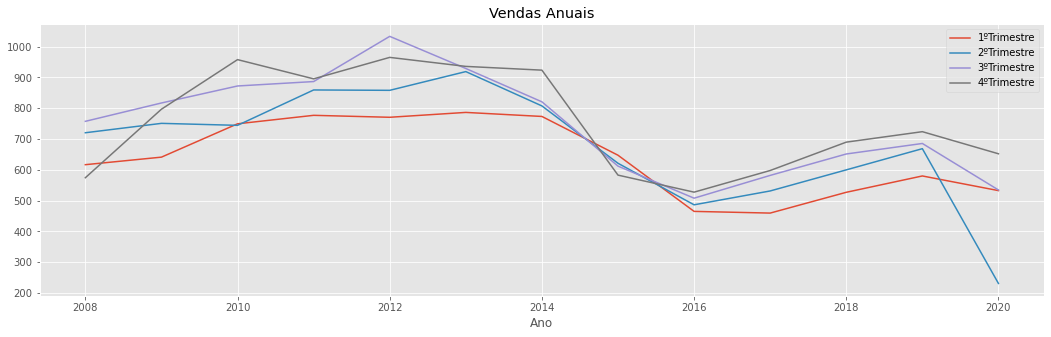

In [23]:
#Vemos que os dois ultimos trimestres de 2012 foram os responsaveis pelo recorde de vendas de 2012
#Vemos também que a diminuiçcao das vendas de 2016 foi bem dividida ao longo do ano 
#dfvendas_trimestre.loc[[4,8]].plot(kind='bar', x='Ano', figsize=(15,8),title='Vendas Anuais', grid='True')
dfvendas_trimestre.plot(kind='line', x='Ano', figsize=(18,5),title='Vendas Anuais', grid='True')
plt.show()

A partir do segundo semestre de 2015 verifica-se o ínicio da tendência que é interrompida no início de 2020 pelo começo da crise gerada pela Pandemia.

In [24]:
#dfvendas_trimestre["1ºTrimestre"].plot()

In [25]:
##Dados Estatisticos sobre as variáveis
dfvendas_trimestre.describe()

,Ano,1ºTrimestre,2ºTrimestre,3ºTrimestre,4ºTrimestre
count,13.00000,13.000000,13.000000,13.000000,13.000000
mean,2014.00000,640.461308,676.790615,745.424308,755.660923
std,3.89444,122.089955,186.965477,163.750803,164.006295
min,2008.00000,459.420000,230.824000,507.840000,527.444000
25%,2011.00000,532.459000,599.824000,611.996000,597.737000
50%,2014.00000,641.168000,720.423000,757.523000,723.890000
75%,2017.00000,770.664000,807.565000,872.350000,923.773000
max,2020.00000,786.479000,919.090000,1033.577000,965.252000


<AxesSubplot:>

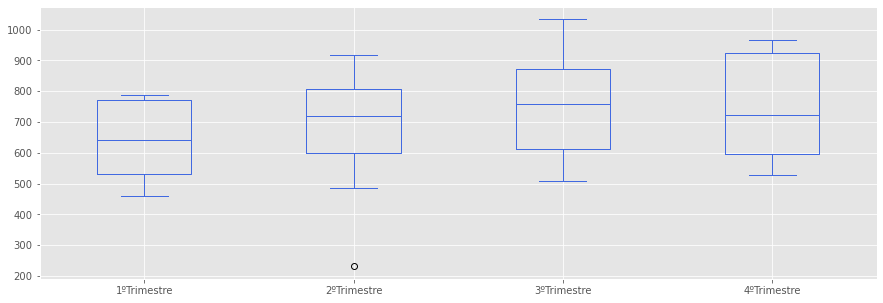

In [26]:
#Gráfico de Caixas para análises estatísticas e outliers(mínimos,máximos,médias, quartis e as discrepâncias) das vendas trimestrais de 2008 a 2020.
dfvendas_trimestre.drop('Ano', axis=1).boxplot(color='#4169e1',figsize='15,5')

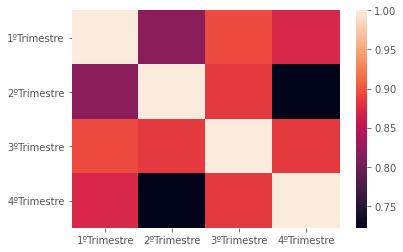

In [27]:
    sns.heatmap(dfvendas_trimestre.drop('Ano', axis='columns').corr()
               )
    plt.show()

Através do mapa de correlação, percebemos forte sasonalidade ao final de cada semestre.

# Análise da Serie Temporal
Qual o comportamento da série temporal do total de vendas mês/ano no periodo de 2008 a 2020?


In [321]:
# Dividindo as bases 60% treino e 40% teste

ts_treino = dfEmplacamentos[['Ano','Total de Vendas']].iloc[4:,0:2].copy()
ts_teste =  dfEmplacamentos[['Ano','Total de Vendas']].iloc[:4,0:5].copy()
ts_treino
#ts_teste

,Ano,Total de Vendas
9,2012,5648.715
8,2013,5591.712
7,2014,5346.627
6,2015,4484.414
5,2016,4007.502
4,2017,4191.298
3,2018,4489.068
2,2019,4679.167
1,2020,3970.892


In [322]:
ts_treino.describe()

,Ano,Total de Vendas
count,9.000000,9.000000
mean,2016.000000,4712.155000
std,2.738613,658.913931
min,2012.000000,3970.892000
25%,2014.000000,4191.298000
50%,2016.000000,4489.068000
75%,2018.000000,5346.627000
max,2020.000000,5648.715000


In [323]:
# Início da base de teste
ts_teste['Ano'] = pd.to_datetime(ts_teste['Ano'], format="%Y")
ts_teste.set_index('Ano', inplace=True)
y_true = ts_teste
ts_teste

,Total de Vendas
Ano,
2008-01-01,4689.900
2009-01-01,5027.142
2010-01-01,5345.279
2011-01-01,5439.667


In [324]:
# Final da base de treino
ts_treino['Ano'] = pd.to_datetime(ts_treino['Ano'], format="%Y")
ts_treino.set_index('Ano',inplace=True)
y_pred = ts_treino
ts_treino

,Total de Vendas
Ano,
2012-01-01,5648.715
2013-01-01,5591.712
2014-01-01,5346.627
2015-01-01,4484.414
2016-01-01,4007.502
2017-01-01,4191.298
2018-01-01,4489.068
2019-01-01,4679.167
2020-01-01,3970.892


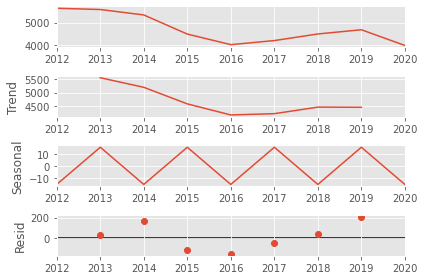

In [325]:
# Decomposição dos dados da base de treinamento
decomposicao = seasonal_decompose(ts_treino, period=2)
imagem = decomposicao.plot()

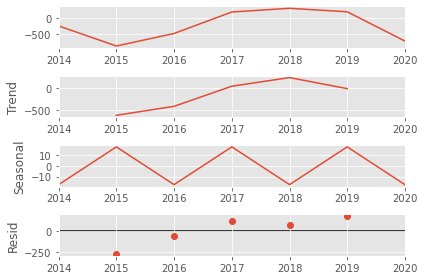

In [326]:
# Decomposição dos dados da base de treinamento
decomposicao = seasonal_decompose(ts_treino_diff_1, freq=2)
imagem = decomposicao.plot()

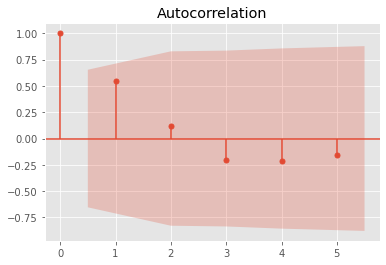

In [327]:
# Gráfico de autocorrelação
sm.graphics.tsa.plot_acf(ts_treino.values.squeeze(), lags=5)
plt.show()

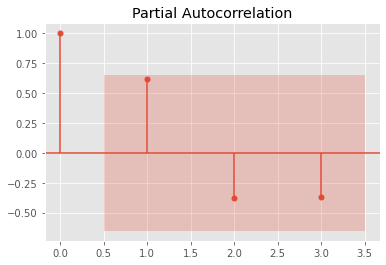

In [328]:
# Gráfico da autocorrelação parcial
sm.graphics.tsa.plot_pacf(ts_treino.values.squeeze(), lags=3)
plt.show()

In [329]:
# Teste Dickey-Fuller
#P-value <0,05 podemos considerar a serie estacionária

teste_adf(ts_treino['Total de Vendas'])

ADF Statistic: -1.190076
p-value: 0.677850
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803


In [330]:
#Os dados não são estacionários, pois o teste no Dickey Fuller  o parametro p éé maior que 0,05
#Normalizando os dados para transforma-los em estacionários

# Aplicando a diferenciação na série e removendo dados nulos
ts_treino_diff_1 = ts_treino.diff()
ts_treino_diff_1 = ts_treino_diff_1.dropna()

ts_treino_diff_1


,Total de Vendas
Ano,
2013-01-01,-57.003
2014-01-01,-245.085
2015-01-01,-862.213
2016-01-01,-476.912
2017-01-01,183.796
2018-01-01,297.770
2019-01-01,190.099
2020-01-01,-708.275


In [331]:
ts_teste_diff_1 = ts_teste.diff()
ts_teste_diff_1 = ts_teste_diff_1.dropna()

ts_teste_diff_1

,Total de Vendas
Ano,
2009-01-01,337.242
2010-01-01,318.137
2011-01-01,94.388


In [332]:
# Teste Dickey-Fuller
# Apos a norlalização dos dados pelo metodo diff do numpy garantindo que p<0,05, podemos considerar a serie estacionária e proseguir 

teste_adf(ts_treino_diff_1['Total de Vendas'])

ADF Statistic: -2.588612
p-value: 0.095374
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


In [369]:
# Criando o modelo
modelo = ARIMA(ts_treino, order=(1,1,0), freq=ts_treino_diff_1.index.inferred_freq)
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [378]:
#Realizando o treinamentos do modelo de acordo com os parâmetros acima
modelo_ajustado = modelo.fit(trend='nc',disp=0)

In [371]:
# Exibe dados do modelo, como valores AIC e BIC obtidos.
modelo_ajustado.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total de Vendas   No. Observations:                    8
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -59.906
Method:                       css-mle   S.D. of innovations            428.312
Date:                Thu, 01 Jul 2021   AIC                            123.812
Time:                        21:33:57   BIC                            123.971
Sample:                    01-01-2013   HQIC                           122.740
                         - 01-01-2020                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ar.L1.D.Total de Vendas     0.3746      0.354      1.058      0.290      -0.319       1.068
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6695           +0.0000j            2.6695            0.0000
-----------------------------------------------------------------------------
"""

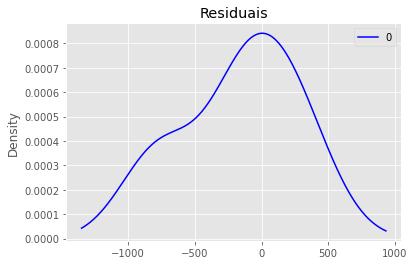

In [372]:
# Gráfico com os erros residuais do modelo ajustado
residuais = pd.DataFrame(modelo_ajustado.resid)

residuais.plot(kind='kde',title="Residuais",color='blue')

plt.show()

In [373]:
print(residuais.describe())

                0
count    8.000000
mean  -164.329154
std    422.920276
min   -779.485514
25%   -360.400110
50%   -105.466302
75%    116.146583
max    362.445801


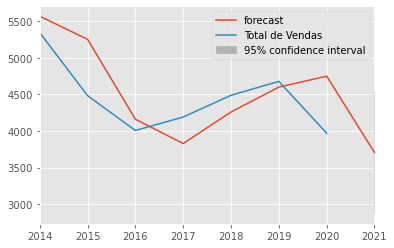

In [374]:
# Dados atuais x Modelo com previsãão para vendas atéé 2022
modelo_ajustado.plot_predict(start= '2014-01-01', end='2021-01-01',dynamic=False)
plt.show()

In [375]:
#Verificação ddo resultado do modelo preditivo através do calculo do RMSE
(residuais**2).mean()

0    183507.936097
dtype: float64

# Treinando novamente o modelo com paramentros diferentes, para diminuir o valor do RMSE


In [418]:
# Criando o modelo
modelo = ARIMA(ts_treino, order=(2,1,0), freq=ts_treino_diff_1.index.inferred_freq)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [419]:
#Realizando o treinamentos do modelo de acordo com os parâmetros acima
modelo_ajustado = modelo.fit(trend='nc',disp=0)

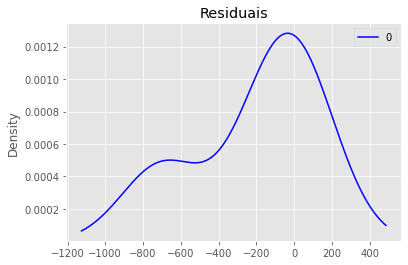

In [420]:
# Gráfico com os erros residuais do modelo ajustado
residuais = pd.DataFrame(modelo_ajustado.resid)

residuais.plot(kind='kde',title="Residuais",color='blue')

plt.show()

In [421]:
print(residuais.describe())

                0
count    8.000000
mean  -205.091808
std    320.215275
min   -723.088576
25%   -334.685422
50%    -70.728379
75%      4.721724
max     82.317902


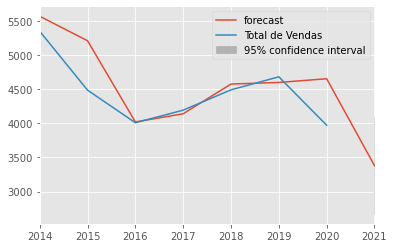

In [422]:
# Dados atuais x Modelo com previsãão para vendas atéé 2022
modelo_ajustado.plot_predict(start= '2014-01-01', end='2021-01-01',dynamic=False)
plt.show()

In [423]:
#Verificação ddo resultado do modelo preditivo através do calculo do RMSE
(residuais**2).mean()

0    131783.244174
dtype: float64

 A alteração dos parametros do ARIMA retornaram um valor menor de RMSE, sinalizando um melhor desempendo do modelo

# Conclusão

Através da técnica de Scrapping foi obtida a série temporal para o emplacamento mensal dos últimos anos.O emplacamento mensal reflete as vendas mensais de veículos novos no Brasil.

Após as análises realizadas conclui-se que o melhor ano para as vendas de veículos novos no Brasil foi o de 2012, enquanto que o ano de 2016 apresentou o menor índice de vendas.
Observando o gráfico Trimestral, pode-se perceber que os melhores Trimestres para a venda de veículos são os 4º trimestres. sendo os 1º Trimestres os que apresentam menor índice de vendas. Foi observado também que em 2015 houve uma inversão de vendas ao longo dos trimestres.
Ao iniciar a análise da série Temporal, constata-se que, para uma análise mais precisa, é necessário a utilização de dataset mais extenso tanto para o treinamento do modelo, decomposição sazonal quanto para a predição dos dados.
A decomposição sazonal demonstrou que a partir de 2015 as vendas de veículos novos estão em uma tendência de alta e que, no período análisado, foi observado alta sazonalidade entre os anos. 
O mercado de vendas de veículos novos no Brasil já sofria com a queda no período de 2014 a 2016. A partir de 2017 o mercado se preparava para um período de alta nas vendas, porém foi interrompido com a crise gerada pela pandemia da covid-19, marcando assim um novo período de baixa a partir de 2020.
Para a predição foram testados os modelos de Regressão linear, Random Forest e o ARMA (ARIMA): os dois primeiros apresentaram altos níveis de erros, provavelmente pela baixa quantidade de dados do nosso DataSet; o modelo ARIMA foi escolhido por possibilitar a manipulação de configurações de forma mais prática para o usuário.
